Initially a series of data structures, files and functions that have to be utilized throughout the analysis have to be stored in the current directory space.  
The code bellow is responsible for downloading the aforementioned data from the storage space.

In [81]:
import os
import pickle as pk
from IPython.display import clear_output
client      = get_bbp_client().document
collab_path = get_collab_storage_path()
ccp_path    = 'CCP v2'
itemlist = client.listdir(os.path.join(collab_path,ccp_path))
for element in itemlist:
    if os.path.isfile('./' + str(element)) == True: continue
    if 'Library.py' in element: continue
    print 'element {} has been downloaded'.format(element)
    local_path = './' + element
    client.download_file(os.path.join(collab_path,ccp_path, element),local_path)
    clear_output()

In [153]:
from cfg import *

The functions and classes shown bellow (find_notebook, NotebookLoader, NotebookFinder) were taken from a tutorial on how to import external jupyter notebooks as modules.
Documentations about the aforementioned functions and classes can be found in this link:  
https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html

In this step a series of libraries whose classes and functions have to be utilized throughout the analysis,  
are being downloaded from the storage space and imported as modules.

In [231]:
elements = ['PrimaryLibrary.ipynb','ParserLibrary.ipynb']
for element in elements:
    local_path = './' + element
    client.download_file(os.path.join(collab_path, element),local_path)

import PrimaryLibrary as PL
imp.reload(PL)

#import ParserLibrary as PrL
#imp.reload(PrL)

clear_output()

## Parameter Initialization

Initializing the parameters of the supervised learning models to be used.  
The models applied in this analysis are: 
*   classification = Random Forest classifier, Logistic Regression classifier
*   regression     = Random Forest regressor,  Ridge regressor

In [196]:
tol_num = 0.001

logreg_params = {'penalty': ['l2'], 'C' : np.logspace(-4, 1,base = 10), \
            'solver': ['newton-cg','lbfgs','sag','liblinear','saga'], \
            'class_weight' : ['balanced']}

rfc_params = {'max_depth': [10, 60, 100, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [25,50,100,200],\
             'criterion': ['gini'],
             'oob_score': [True], 'random_state' : [None],\
             'max_features' : ['auto'], 'class_weight' : ['balanced']}

ridge_params = {'alpha': [10e-4,10e-3,10e-2,0.5,1,2.5,5,7.5,10,100],
              'solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'saga'],
              'tol': [tol_num], 'max_iter' : [1000]}


sv_models = [GridSearchCV(LogisticRegression(), param_grid = logreg_params, scoring = 'f1', cv = 3, n_jobs = -1),
             GridSearchCV(RandomForestClassifier(), param_grid = rfc_params, scoring = 'f1', cv = 3, n_jobs = -1),
             DummyClassifier(),
             GridSearchCV(Ridge(), param_grid = ridge_params, 
                          scoring = 'neg_mean_squared_error', 
                          cv = 3, n_jobs = -1),
             RandomForestRegressor(n_estimators = 100),
             DummyRegressor()
            ]

Loading a series of data structures that will be used in the analysis.  
The data are being loaded for reasons of time efficiency.  
The Classes_and_Modules notebook provides comments and descriptions for the functions in which the data were created

In [217]:
leaves         = pk.load(open('leaf_nodes.pkl','rb'))
GeneExp        = h5py.File('G_Exp.hdf5', 'r')['dataset1']
GeneMeta       = pk.load(open('GeneMeta.pkl','r'))
GeneAcros      = np.asarray([val['genes'][0]['entrez_id'] for val in GeneMeta])
GeneNames      = np.asarray([val['genes'][0]['acronym'] for val in GeneMeta])
GeneMetaDict   = {val : GeneNames[idx] for idx,val in enumerate(GeneAcros)}
ConDict        = pk.load(open('CreLineDict.pkl','rb'))
folder_name    = 'Paper4/'
targetprofiles = OrderedDict()

Storage of information regarding the mouse brain structures.
The targetprofiles dictionary specializes in target areas 
with regards to connectivity patterns in the mouse mesoconnectome.
Its keys are: 
   *           str_acronym = acronyms of target areas/structures
   *           alt laminar profiles = laminar profiles of cortical structures
   *           father               = the brain regions in which each target belongs to      
   
   
The leaf_keys contain information about target areas that are present on the finest possible level of description.
For instance areas called VISp (primary visual area) and VISp l1 (primary visual area, layer 1) could both be found 
in the dataset, and therefore the leaf_keys are being used to filter out VISp as a non-leaf key in the structure hierarchy
since a finer description is present (VISp l1).

In [218]:
with open('acr2parent.json', 'r') as fp:
     acr2parent = json.load(fp)
with open('structures.csv','rb') as fp:
     structure = PL.readtable(fp)  
     
struct_idx_dict = {val:idx for idx,val in enumerate(structure['id'])}
targetprofiles['str_acronym'] = [val for val in structure['acronym']]
targetprofiles['alt laminar profiles'] = PL.LaminarRegistration(targetprofiles['str_acronym'])

# storing layer 1 and layer 4 related areas for a latter analysis
l4_vals = [idx for idx,val in enumerate(targetprofiles['alt laminar profiles']) if val == 'layer 4']
l1_vals = [idx for idx,val in enumerate(targetprofiles['alt laminar profiles']) if val == 'layer 1']
lam_to_idx = {val:targetprofiles['alt laminar profiles'][idx] for idx,val in enumerate(structure['id'])}

# storage of leaf-level structures
leaf_keys = [int(val[0]) for val in leaves]  

for key in targetprofiles.keys():
    targetprofiles[key] = [val for idx,val in enumerate(targetprofiles[key]) if idx in leaf_keys]
targetprofiles['father'] = []
for strut in targetprofiles['str_acronym']:
    father = [val for key,val in acr2parent.items() if key == strut]
    if father == []:
       targetprofiles['father'].append(strut) 
    else:
       targetprofiles['father'].append(father[0])  

The params dictionary stores information which will be used throughout the analysis.
It will be passed as a parameter through the functions and updated at various steps. 

In [219]:
params = {'alter' : None, 'fetch' : 'all', 'distance prior': False,\
          'acronyms': targetprofiles['str_acronym'],\
          'method': 'classification', 'leaf': True, \
          'validation' : [StratifiedKFold(n_splits = 3, shuffle = True), KFold(n_splits = 3, shuffle = True)],\
          'prefix': 'Paper4/', 'primary models': [i for i in sv_models], \
          'Gene Acronyms Original': GeneAcros, 'Gene Metadata': GeneMetaDict,
          'leaf_keys' : leaf_keys}
reload_data = False

Conversion of the Gene Expression dataset as a numpy array for analysis,  
initialization of various dictionaries to store preprocessed data
and results per tracer category (driver line),  
and initialization the the MesoconnectomePredictor for its
functions to be utilized

In [222]:
GeneExp = np.asarray(GeneExp, dtype = np.float32)
ConStr_proc = {}; GeneExp_proc = {}; y = {}

# matrix reduction to leaf-level structures
GeneExp  = GeneExp[leaf_keys,:]  
MesoPred = PL.MesoconnectomePredictor()

## Predictive Pipeline  
### Author: Nestor Timonidis
In our examples I utilize the unionized anatomical tract tracing data taken from the Allen Institute for Brain Science, as shown in the ParserLibrary notebook. The data come in the form of a dictionary with nested matrices, where each dictionary corresponds to a tracer category like wild type or Syt6-Cre_KI148 cre-line experiments for instance.   
In order to demonstrate the MesoPred tool, a number of categories are selected as shown bellow. This analysis can take more than a day if run for all possible tracer categories. Therefore, for reasons of time efficiency one could skip this cell and move to the next one where the results can be loaded by stored pickle files.


In this pipeline a number of steps is being followed:  
0.  Selection of the tracer category (driver) of interest, reduction of tracing data to the leaf-level structures and storage of a number of parameters to be used in the analysis, such as the layer profiles and abbreviations of the target areas of the dataset.
1.  Preprocessing of the gene expression and tract tracing data. The function called in that step is PreProcessing
2.  Prediction with a logistic or linear ridge regression model using the cross-validation method for performance evaluation. The function called in that step is CustomCrossval.
3.  Prediction with a random forest classifier or regressor model using the cross-validation method for performance evaluation. The function called in that step is CustomCrossval.
4.  Prediction with a control (baseline) model using the cross-validation method for performance evaluation. The function called in that step is CustomCrossval.
5.  Storage of the predicted connectivity patterns, probability scores and gene importance (coefficient) scores per tracer in dictionaries stratified by the tested driver categories. The function called in that step is UnravelResults.
6.  Based on the stored connectivity patterns and the actual (ground truth) ones, evaluation of the predictive process with series of statistical measures. Examples include r squared and root mean squared error for regression, and f1-score and area under the roc curve for classification. The function called in that step is Evaluation.
8. Estimate the stability of the fittest model based on the optimal hyperparameters selected for each fold of the CustomCrossval function (step 3). In case that the model is considered as stable, then the model fits the whole data with the optimal hyperparameters

In [221]:
ClfResults_ridge = MesoPred.PredictivePipeline(ConDict, GeneExp, params)
for key in ConDict.keys():
    if reload_data == False: continue 
    ## Step 0:
    # measure used not to repeat predictions that have already been done
    outfile = key + '_all_results' 
    ConStr  = np.asarray(ConDict[key]['ConMat'], dtype = np.float32)
    ConStr = ConStr[leaf_keys,:]
    params['injection_number'] = np.shape(ConStr)[1]  
    params['cre-line'] = key
    params['structure-abbrev'] = ConDict[key]['structure-abbrev']
    params['layer'] = ConDict[key]['layer'][0]
    params['cell-type'] = ConDict[key]['cell-type'][0]
    params['method'] = 'regression'
 
    print 'Driver line: '+ str(key) + '\nTracer number: ' + str(ConStr.shape[1]) 
    
    ## Step 1:
    GeneExp_proc[key], ConStr_proc[key], y[key], sc_sqrt = MesoPred.PreProcessing(
                                                    GeneExp, ConStr, params)
    str_copy = np.delete(targetprofiles['str_acronym'],params['nanCons'],0); str_copy = np.delete(str_copy,params['nanGenes'],0)
    pk.dump(params, open('updated_params.pkl','wb'))
    start = time.time()
    ## Step 2:
    print 'Ridge ' + params['method'] +  ' predictive phase ..'    
    ridge_pred  = list(PL.CustomCrossval(params['primary models'][3], GeneExp_proc[key], 
                                         ConStr_proc[key], params['validation'][1]))
    ridge_pred.append(GeneExp_proc[key])
    #pk.dump(ridge_pred, open(params['cre-line'] + '_ridge_pred.pkl', 'wb'))
    print 'Ridge ' + params['method'] +  ' has been completed' 
    
    ## Step 3:
    print 'Random forest ' + params['method'] + ' predictive phase ..'
    rf_pred  = list(PL.CustomCrossval(params['primary models'][4], GeneExp_proc[key], 
                                      ConStr_proc[key], params['validation'][1]))
    rf_pred.append(GeneExp_proc[key])                                  
    #pk.dump(rf_pred, open(params['cre-line'] + '_rf_pred.pkl','wb'))
    print 'Random forest ' + params['method'] +  ' has been completed' 
    
    ## Step 4:
    print 'Control model ' + params['method'] +  ' predictive phase ..'
    bl_pred  = list(PL.CustomCrossval(params['primary models'][5], GeneExp_proc[key], 
                                      ConStr_proc[key], params['validation'][1]))
    bl_pred.append(GeneExp_proc[key])                                       
   
    #pk.dump(bl_pred, open(params['cre-line'] + '_bl_pred.pkl','wb'))
    print 'Control ' + params['method'] +  ' has been completed'  
    
    end = time.time() 
    print  'Elapsed time: ' + str((end - start)/60)   
    
    ## Step 5:
    print 'Unraveling of results phase ..' 
    ClfResults_ridge = MesoPred.UnravelResults(ridge_pred, params, sc_sqrt)
    ClfResults_rf = MesoPred.UnravelResults(rf_pred, params, sc_sqrt)
    #pk.dump(ClfResults_rf, open(outfile + '_rf.pkl','wb'))
    ClfResults_bl = MesoPred.UnravelResults(bl_pred, params, sc_sqrt)
    #pk.dump(ClfResults_bl, open(outfile + '_bl.pkl','wb')) 
     
    ## Step 6:
    print 'Evaluation of results phase ..'
    MesoPred.Evaluation(ClfResults_ridge, ClfResults_rf, ClfResults_bl, params) 
    
    # Step 7:
    unanimity_thr = 0.2
    verdict, params_to_fit = MesoPred.StabilityInvestigator(ClfResults_ridge['Model Storage'], unanimity_thr)
    if verdict == 'Full Fit': 
        final_model = Ridge(**params_to_fit).fit(ridge_pred[5], ridge_pred[2])
    elif verdict == 'Partial Fit': 
        final_model = [Ridge(**model.best_params_).fit(ridge_pred[5], ridge_pred[2])\
                       for model in ClfResults_ridge['Model Storage']]
    
    ClfResults_ridge['final model'] = final_model
    final_model = []
    pk.dump(ClfResults_ridge, open(outfile + '_ridge.pkl','wb'))
    
    clear_output()

Driver line: Syt6-Cre_KI148
Tracer number: 59
Data cleaning phase ...

Size before data cleaning (1038, 59)
Size after intermediate cleaning (585, 59)
Size after data cleaning (428, 59)
Data imputation phase ...

Data normalization phase ....



/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Removing outliers ... Reduced dim: (428, 3318) (428, 59)
Ridge regression predictive phase ..


/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Ridge regression has been completed
Random forest regression predictive phase ..


/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Random forest regression has been completed
Control model regression predictive phase ..
Control regression has been completed
Elapsed time: 39.3568694353
Unraveling of results phase ..
Evaluation of results phase ..


TypeError: 'StandardScaler' object is not iterable

In case that a set of results from a number of tracer categories have been stored,  
they can be loaded as shown bellow in order to save time.   
The data from the ridge regression model are being used   
due to the model's superior performance over the rest of  
the models as shown by the cross-validation evaluation method.

In [13]:
ClfResults_ridge = {}; ridge_pred = {}
unanimity_thr    = 0.2
params           = pk.load(open('updated_params.pkl','rb'))
for key in ConDict.keys():
    if os.path.isfile('./' + key + '_all_results' + '_ridge.pkl') == True:
        infile = key + '_all_results' + '_ridge.pkl'
        print infile
        tmp = pk.load(open(infile,'r'))
        ClfResults_ridge[key] = {key:val for key,val in tmp.items() 
                                 if key != 'Model Storage'}
        ridge_pred[key] = [ClfResults_ridge[key]['y_actual'],
                           ClfResults_ridge[key]['y_preds'],
                           ClfResults_ridge[key]['Gene Expression']]
      

Syt6-Cre_KI148_all_results_ridge.pkl
Ntsr1-Cre_GN220_all_results_ridge.pkl
Sim1-Cre_KJ18_all_results_ridge.pkl
Efr3a-Cre_NO108_all_results_ridge.pkl
Chrna2-Cre_OE25_all_results_ridge.pkl
A93-Tg1-Cre_all_results_ridge.pkl
Tlx3-Cre_PL56_all_results_ridge.pkl
Rbp4-Cre_KL100_all_results_ridge.pkl
Rorb-IRES2-Cre_all_results_ridge.pkl
Scnn1a-Tg3-Cre_all_results_ridge.pkl
Nr5a1-Cre_all_results_ridge.pkl
Sepw1-Cre_NP39_all_results_ridge.pkl
Emx1-IRES-Cre_all_results_ridge.pkl
Cux2-IRES-Cre_all_results_ridge.pkl
wild_type_all_results_ridge.pkl


One of the last demonstrations regarding the predictive pipeline is about binarized connectivity patterns. This could be useful in the case that a particular researcher is not interested in the connectivity strength between two brain areas but in the presence of connections between areas, whose strength exceeds a certain threshold. For that reason, the Convert2ROC function is being called for all predicted connectivity patterns.     
The idea is the utilize the Area under the ROC curve (AURoc) as an evaluation measure in order to estimate the most optimal binarizing threshold. The threshold for which the AURoc is being maximized is selected as the most optimal. 
The steps that describe this procedure are being explained in the Convert2ROC function.

In [ ]:
#MesoPred = MesoconnectomePredictor(GeneExp, ConDict['wild_type']['ConMat'])
cutoff_col = {}
for driver_line in ridge_pred.keys():
    print 'driver line: ' + str(driver_line)
    ClfResults_ridge[driver_line]['cutoff'] = MesoPred.Convert2ROC(ridge_pred[driver_line][1],ridge_pred[driver_line][0])

Lets take the case where we want to binarize the connectivity patterns in experiments belonging to the cre-line tracers tested in our analysis such as Cre_GN220. We utilize the our results from the previous function as shown bellow 

In [ ]:
for driver_line in ClfResults_ridge.keys():
    outfile = driver_line + '_all_results'
    print driver_line
    experiments_len = np.shape(ridge_pred[driver_line][0])[1]
    for tracer_num in range(experiments_len):  
        ClfResults_ridge[driver_line]['binary_patterns'] = PL.BinarizeTheVector\
                                                         (ClfResults_ridge[driver_line]['y_actual'][:,tracer_num],\
                                                            ClfResults_ridge[driver_line]['cutoff'][tracer_num][0])
    pk.dump(ClfResults_ridge[driver_line], open(outfile + '_ridge.pkl','wb'))        
            

## VISUALIZATION CHAPTER  
### Authors: Nestor Timonidis, Paul Tiesinga
In this section, a number of steps are being followed   
for visualizing brain slices containing gene expression   
or connectivity information


Utilization of the MouseConnectivityCache (mcc) tool, provided by the Allen Institute for Brain Science Software Development Toolkit (SDK) at:  
https://alleninstitute.github.io/AllenSDK/_modules/allensdk/core/mouse_connectivity_cache.html    
The cortical flatmap templates used in this analysis, were downloaded from the informatics-archive of the Allen Institute for Brain Science:   
http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2016/  
The cortical_map_10.py script is a slightly modified version of the cortical_map.py script that was provided by the Allen Institute's github as part of the mouse_connectivity_models tool:   
https://github.com/AllenInstitute/mouse_connectivity_models  
The difference with the original script is that cortical_map_10 is modified to incorprorate cortical flatmap templates of 10 micrometer resolution.  
With the mcc tool, the annotation volume of the mouse brain is being downloaded in both 25 and 10 micrometer resolution for visualization purposes.

In [ ]:
mcc_25 = MouseConnectivityCache(resolution = 25)
mcc_10 = MouseConnectivityCache(resolution = 10)
Annotation_25, annot_info = mcc_25.get_annotation_volume()
Annotation_10, annot_info = mcc_10.get_annotation_volume()

### Application of a set of experiment ids in the brain visualization tools (Brain Plotter)  

In order to make a cortical flatmap visualization for the mouse cortex,    
we need to initially ensure that we have reduced the complexity  
of structural brain areas to a layer inspecific level that corresponds    
to clear anatomically distinct areas like the primary visual or motor cortex.   
Therefore we utilize the MouseConnectivityCache tool to get the ontology    
tree of brain areas, then we reduce it by the isocortex and for each    
isocortical area, we take the identity of its father node, or an area  
belonging up in the tree hierarchy.      
Having achieved that, the next step is to replace the identity of each    
area in the annotation volume structure by the father identity.  

In [ ]:
# grab the StructureTree instance
structure_tree = mcc_10.get_structure_tree()
oapi           = OntologiesApi()
# Get isocortex summary structures
kid_to_father = {}
summary_structures = structure_tree.get_structures_by_set_id([688152357])
for val in summary_structures:
    kids = structure_tree.descendant_ids([val['id']])
    for kid in kids[0]:
        kid_to_father[kid] = val['id']

# For each distinct isocortical area, replace its children annotation with the area's id
father_acros_indices = {val['acronym']:val['id'] for val in summary_structures}

#store the original annotation shape because it will be flatten for computational simplicity when updating the parent nodes
orig_annot_shape = np.shape(Annotation_10)
flat_annot = np.ndarray.flatten(Annotation_10, order = 'C')

# Create a copy of the annotation structure that reduces areas to their parent nodes
Annotation_copy = np.zeros(np.shape(flat_annot))

for kid_id,parent_id in kid_to_father.items():
    tmp  = flat_annot == int(kid_id)
    nzero_ids = np.nonzero(tmp)
    Annotation_copy[nzero_ids] = parent_id 
     
with h5py.File('Annotation_copy.hdf5','w') as f2:
     f2.create_dataset('dataset1', data = Annotation_copy)

Selection of the 11th and 21st experiment for demonstration of the BrainPlotter tool.   
Data structures for storing the mapping of unionized projections to volumetric scale,  
for the actual and predicted patterns, are being initialized.  
Moreover, the dictionary that maps the identities of structures to their positions  
in the original raw unionized dataset is being updated to include only the   
structures that were used in the predictive pipeline.  

In [ ]:
tracer_for_selection = 'Ntsr1-Cre_GN220'
with open('structures.csv','rb') as fp:
     structure = PL.readtable(fp)  
     struct_idx_dict = {val:idx for idx,val in enumerate(structure['id'])}
experiment_to_vis = [10,20]
UnionToVoxel_pred_25 = {}; UnionToVoxel_pred_10 = {}; UnionToVoxel_25 = {}; UnionToVoxel_10 = {}
struct_idx_dict_cp = struct_idx_dict.copy()
for key,value in struct_idx_dict.items():
    if value not in params['remaining_indices']:
       del struct_idx_dict_cp[key]
struct_idx_dict = struct_idx_dict_cp    
#Annotation_copy = np.asarray(h5py.File('Annotation_copy.hdf5','r')['dataset1'], dtype = np.int32)

In [213]:
element    = 'PrimaryLibrary.ipynb'
local_path = './' + element
client.download_file(os.path.join(collab_path, element),local_path)

import PrimaryLibrary as PL
imp.reload(PL)

#import ParserLibrary as PrL
#imp.reload(PrL)

clear_output()

test case: Unionized 2 matrices, 10


PrimaryLibrary.ipynb:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
PrimaryLibrary.ipynb:27: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
PrimaryLibrary.ipynb:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


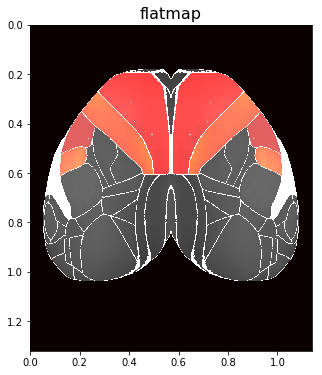

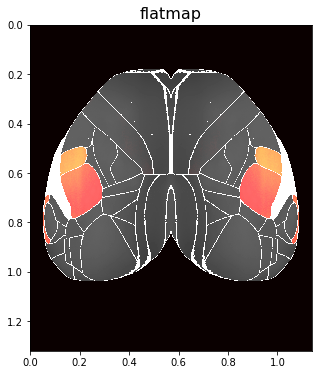

test case: Unionized 2 matrices, 25, layer specificity


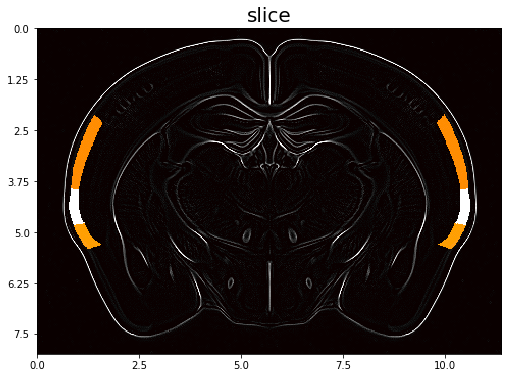

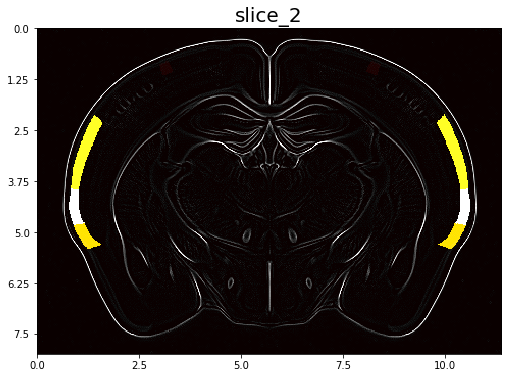

test case: Unionized 1 matrix, 10, layer specificity


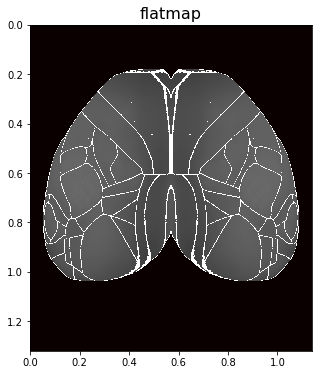

test case: Unionized 2 matrices, 10, layer specificity


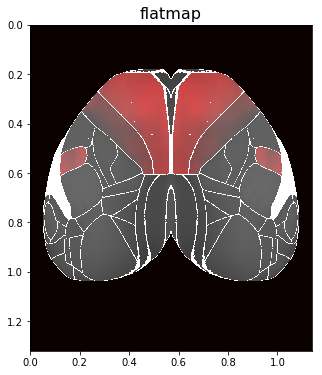

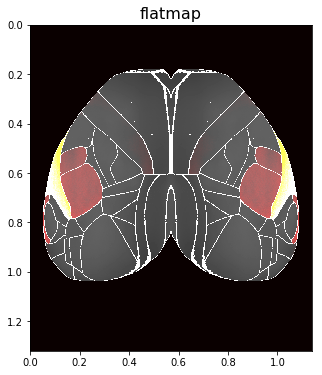

test case: Unionized 2 matrices, 10


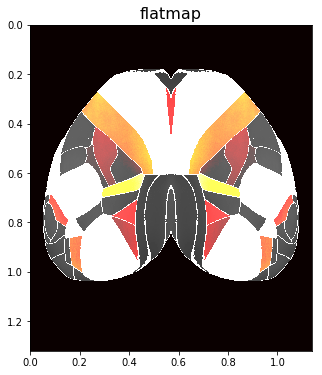

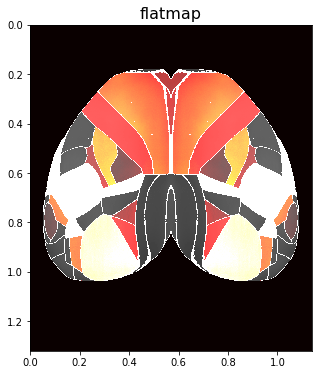

test case: Unionized 2 matrices, 25, layer specificity


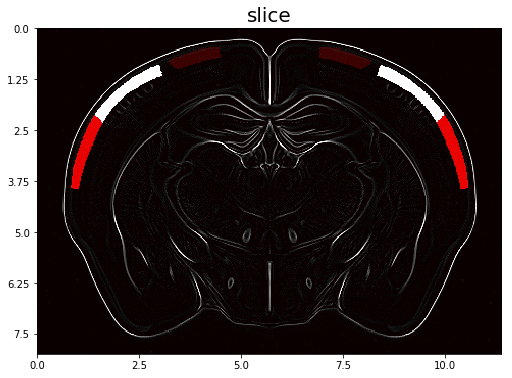

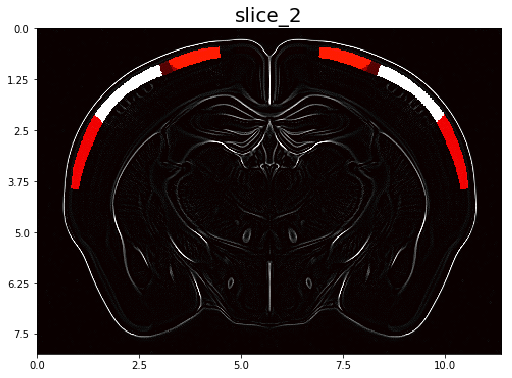

test case: Unionized 1 matrix, 10, layer specificity


KeyboardInterrupt: 

In [77]:
experiment_to_vis = [10,20]
tracer_for_selection = 'Ntsr1-Cre_GN220'
for j,experiment in enumerate(experiment_to_vis):
    
    experiment_id = ConDict[tracer_for_selection]['id'][experiment]
    #BP_25 = PL.BrainPlotter(exp_id = experiment_id, driver = tracer_for_selection, 
    #                        resolution = 25)
    #print 'bogus test case '  ---> success
    #BP_25.fit(projection = ridge_pred[tracer_for_selection][0][:,j], layer_profile = None, 
    #          projection2 = None, 
    #          chosen_indices = None) 
    
    #print 'test case: Unionized 2 matrices, only 25 '
    #BP_25.fit(projection = ridge_pred[tracer_for_selection][0][:,j], layer_profile = None, 
    #          projection2 = ridge_pred[tracer_for_selection][1][:,j], 
    #          chosen_indices = params['remaining_indices'])
    #BP_25.plot_slice()
    
    #print 'test case: Raw 25 '
    #BP_25_raw = PL.BrainPlotter(exp_id = experiment_id, driver = tracer_for_selection, 
    #                            resolution = 25)
    #BP_25_raw.fit()
    #BP_25_raw.plot_slice()
    
    #print 'test case: Raw 10 '
    #BP_10_raw = PL.BrainPlotter(exp_id = experiment_id, driver = tracer_for_selection, 
    #                            resolution = 10)
    #BP_10_raw.fit()
    #BP_10_raw.plot_flatmap()
    
    #print 'test case: Unionized 1 matrix, 10'
    #BP_10_1 = PL.BrainPlotter(exp_id = experiment_id, driver = tracer_for_selection, 
    #                        resolution = 10)
    #BP_10_1.fit(projection = ConDict[tracer_for_selection]['ConMat'][:,j], layer_profile = None, 
    #            projection2 = None, 
    #            chosen_indices = None)
    #BP_10_1.plot_flatmap()
    
    print 'test case: Unionized 2 matrices, 10'
    BP_10_2 = PL.BrainPlotter(exp_id = experiment_id, driver = tracer_for_selection, 
                      resolution = 10)
    BP_10_2.fit(projection = ridge_pred[tracer_for_selection][0][:,j], layer_profile = None, 
           projection2 = ridge_pred[tracer_for_selection][1][:,j], 
           chosen_indices = params['remaining_indices'])
    BP_10_2.plot_flatmap()
    
    #print 'test case: Unionized 1 matrix, 25, layer specificity'
    #BP_25 = PL.BrainPlotter(exp_id = experiment_id, driver = tracer_for_selection, 
    #                        resolution = 25)
    #BP_25.fit(projection = ConDict[tracer_for_selection]['ConMat'][:,j], layer_profile = 'layer 1', 
    #          projection2 = None, 
    #          chosen_indices = None)
    #BP_25.plot_slice()
    
    print 'test case: Unionized 2 matrices, 25, layer specificity'
    BP_25 = PL.BrainPlotter(exp_id = experiment_id, driver = tracer_for_selection, 
                            resolution = 25)
    BP_25.fit(projection = ridge_pred[tracer_for_selection][0][:,j], layer_profile = 'layer 2/3', 
              projection2 = ridge_pred[tracer_for_selection][1][:,j], 
              chosen_indices = params['remaining_indices'])
    BP_25.plot_slice()
    
    print 'test case: Unionized 1 matrix, 10, layer specificity'
    BP_10 = PL.BrainPlotter(exp_id = experiment_id, driver = tracer_for_selection, 
                            resolution = 10)
    BP_10.fit(projection = ConDict[tracer_for_selection]['ConMat'][:,j], layer_profile = 'layer 4', 
              projection2 = None, 
              chosen_indices = None)
    BP_10.plot_flatmap()
    
    print 'test case: Unionized 2 matrices, 10, layer specificity'
    BP_10 = PL.BrainPlotter(exp_id = experiment_id, driver = tracer_for_selection, 
                            resolution = 10)
    BP_10.fit(projection = ridge_pred[tracer_for_selection][0][:,j], layer_profile = 'layer 5', 
              projection2 = ridge_pred[tracer_for_selection][1][:,j], 
              chosen_indices = params['remaining_indices'])
    BP_10.plot_flatmap()
      
clear_output()

For each one of the selected experiments:  
0.   Initializing the data for usage during the visualization process.
1.   Mapping of unionized projections to volumetric space for actual and predicted projection patterns,   using the FromUnion2Voxel function.
2.   Repetition of step 1 for 10 micrometers instead of 25, since the cortical flatmap visualization requires 10 micrometer resolution, while the brain slice visualization requires 25 micrometers.
3.   Initialization of the BrainPlotter class instances,
4.   Call of the plot_slice function to visualizing projections of the currently selected experiment in the superior-inferior and left-right coordinates using a brain slice.
5.   Call of the plot_flatmap function to visualizing projections of the currently selected experiment on the mouse cortex, using a cortical flatmap.

In [ ]:
for j,experiment in enumerate(experiment_to_vis):
    
    # Step 0
    key_to_save = tracer_for_selection + '_' + str(j)
    exp_id = ConDict[tracer_for_selection]['id'][j]
    ConStr = ConDict[tracer_for_selection]['ConMat']
    Pred_ConStr = ridge_pred[tracer_for_selection]
    
    # Step 1
    start = time.time()
    UnionToVoxel_25[key_to_save], UnionToVoxel_pred_25[key_to_save] = PL.FromUnion2Voxel(
         Annotation_25, struct_idx_dict, Pred_ConStr[1][:,j], params, 
         Pred_ConStr[0][:,j])
    end = time.time() 
    print  'Elapsed time: ' + str((end - start)/60)
    with h5py.File('./UnionToVoxel_25_for_' + str(key_to_save) + '.hdf5','w') as fp:
        fp.create_dataset('dataset1', data = UnionToVoxel_25[key_to_save], 
                          dtype = np.float32) 
    with h5py.File('./UnionToVoxel_25_pred_for_' + str(key_to_save) + '.hdf5','w') as fp:
        fp.create_dataset('dataset1', data = UnionToVoxel_pred_25[key_to_save], dtype = np.float32)  
    
    # Step 2   : Due to limitations on available memory, we shall skip the volumetric mapping on the 10 micrometer 
    #            resolution. We shall instead show in the next cell the 10 micrometer cortical flatmap on the 
    #            actual raw volumetric data
    
    # UnionToVoxel_10[key_to_save], UnionToVoxel_pred_10[key_to_save] = \
    #                  FromUnion2Voxel(Annotation_10, struct_idx_dict,\ 
                                       #Pred_ConStr[1][:,j], Pred_ConStr[0][:,j])    
        
    # Step 3   
    #BP_10 = PL.BrainPlotter(mcc_10, experiment_id = exp_id, res = 10, 
                          #driver = tracer_for_selection + str(exp_id))
    BP_25 = PL.BrainPlotter(mcc_25, experiment_id = exp_id, 
                            res = 25, driver = tracer_for_selection + str(exp_id))
    
    # Step 4
    BP_25.plot_slice(struct_idx_dict, 'None', Annotation_25, 
                     matrix = UnionToVoxel_25[key_to_save],\
                     savefile = 'slice visualization for : ' + 
                     str(tracer_for_selection) + ' ' +  str(j+1) + '.png')
    BP_25.plot_slice(struct_idx_dict, 'None', Annotation_25, 
                     matrix = UnionToVoxel_pred_25[key_to_save],\
                     savefile = 'slice visualization for : ' + 
                     str(tracer_for_selection) + ' ' +  str(j+1) + ' (predicted).png')

    # Step 5:  Skipping the step (see Step 2 comments)
    # BP_10.plot_flatmap('None', Annotation_copy, matrix = UnionToVoxel_10[key_to_save],\
    #                   savefile = 'flatmap visualization for : ' 
                        #+ str(tracer_for_selection) + ' ' +  str(j+1) + '.jpg')
    # BP_10.plot_flatmap('None', Annotation_copy, matrix = UnionToVoxel_pred_10[key_to_save],\
     #                  savefile = 'flatmap visualization for : ' + str(tracer_for_selection) 
                        #+ ' ' +  str(j+1) + '.jpg') 

We are also interested in producing the aforementioned figures with the actual raw volumetric data. Therefore, steps 3-5 are repeated without giving any volumetric matrix as input to the plot_slice and plot_flatmap functions. In that case, the identities of the original experiments are used to download and visualize the actual raw data.

In [ ]:
for j,experiment in enumerate(experiment_to_vis):
    
    # Step 0
    exp_id = ConDict[tracer_for_selection]['id'][j]

    # Step 3          
    BP_10 = PL.BrainPlotter(mcc_10, experiment_id = exp_id, res = 10, 
                            driver = tracer_for_selection + str(exp_id))
    BP_25 = PL.BrainPlotter(mcc_25, experiment_id = exp_id, res = 25, 
                            driver = tracer_for_selection + str(exp_id))
    
    # Step 4
    BP_25.plot_slice(struct_idx_dict, 'None', Annotation_25, matrix = 'None',\
                     savefile = 'slice visualization for : ' + 
                     str(tracer_for_selection) + ' ' +  str(j+1) + '.png')
    # Step 5
    BP_10.plot_flatmap('None', Annotation_10, matrix = 'None',\
                       savefile = 'flatmap visualization for : ' + 
                       str(tracer_for_selection) + ' ' +  str(j+1) + '.jpg')
    

## Link to Scalable Brain Atlas Composer Section
### Authors: Rembrandt Bakker, Nestor Timonidis

In this part, the Scalable Brain Atlas (SBA) Composer visualization tool is being used to visualize actual and predicted data that have been used and processed throughout the analysis.      
The website of the SBA Composer can be accessed by this link:  
https://scalablebrainatlas.incf.org/composer/?template=ABA_v3  
A series of steps bellow describe the visualization process.

In order for results to be visualized, a conversion to json format is necessary.
Therefore the dictionary bellow indicates the format that results must have in order to be visualized.
Specifically:  
*    provider    = the name of the tool to be used. sba stands for scalable brain atlas.
*    atlas       = the Common Coordinate Framework (CCF) version that was used by the Allen Institute to process the raw data that the user has used throughout the analysis. In this case ABA_v3 stands for Allen Brain Atlas version 3, since our data were processed according to that framework.  
*    orientation = the orientation used in 3D space for the input. RAS stands for: right-anterior-superior.
*    unit        = the scaling unit. mm stands for milimiters.


In [ ]:
JSonDict = {'bas': {'provider': "sba",
             'atlas': "ABA_v3",
             'orientation': "RAS",
             'unit': "mm"},
             'style': {}, 'markers':[]} 

According to the aforementioned format, we select predictions of all tracing data tested by our predictive model.  
For non wild-type, meaning cre-line experiments, we also incorporate information regarding the layer and cell types  
most commonly expressed in the injected source brain areas.  
Furthermore, we select to visualize the r2 measure for evaluation of predictive performance.   
For each individual experiment we embed the r2 measure in the spatial locations of the structural  
brain area corresponding to the injected source location.

In [ ]:
JSonDict = MesoPred.Convert2JSON(ClfResults_ridge, ConDict, pred_measure = 'r2')

In this step, a sbaInterface_class object is being initialized to be used in the visualization process.    
The sbaInterface_class acts as the interface between our data and the tool.  
As an initial test, a window with the SBA composer opens without data.  

In [ ]:
#from IPython.display import display, Javascript, clear_output

# SBA Composer page to load: here it is the -dev version and atlas ABA_v3
sbaHost = 'https://scalablebrainatlas.incf.org/composer-dev';
sbaUrl = sbaHost+'/?template=ABA_v3';

class sbaInterface_class:
    def __init__(this,sbaUrl):
        # In Javascript, load sbaInterface.js and create a new sbaInterface object
        display(Javascript("""
            var script = document.createElement('script');
            script.src = '{}/../js/sba-interface.js';
            script.onload = function() {{
              window.global_sbaInterface = new sbaInterface_class('{}');
            }}
            document.head.appendChild(script)
        """.format(sbaHost,sbaUrl)))
        clear_output()
        
    def send(this,sbaCommand):
        display(Javascript("""window.global_sbaInterface.send({})""".format(json_encode(sbaCommand))))
        clear_output() # prevents clogging the Jupyter notebook

sbaInterface = sbaInterface_class(sbaUrl)


In this step, the predictive results in json format  
are being given as input to the send function of the    
sbaInterface object. The result is visualization of   
our selected measure across the mouse brain.  

In [ ]:
#sbaInterface.send(json.dumps({'method':'Composer.scatter3d' ,'params' : JSonDict}))
#sbaCommand = {
#    "method":"Composer.scatter3d",
#    'params' : JSonDict
#}
sbaCommand = BP_10.Call_SBA(JSonDict, mode = 'json')
sbaInterface.send(sbaCommand)

After the prediction of connectivity patterns with the training of unionized data has been evaluated   
and visualized,the next and final step is the visual inspection of the connectivity patterns in the   
volumetric space of 25 or 10 micrometers. In this example, the UnionToVoxel_10 is being used,   
that in previous steps stored a mapping of the actual and predicted connectivity patterns   
in the volumetric space. For each individual experiment whose actual and predicted patterns   
have been stored by UnionToVoxel_10, the data structure is being converted into nifti format  
and given as input to the send function in order to be visualized.  
Following that command, a new window will pop-up and the user can  visually inspect the patterns  
by zooming in/out and rotating the mouse brain.

In [ ]:
'''nifti_urls = PL.Save2Nifti(UnionToVoxel_25, affine_scale = 0.025)
exp_to_select = nifti_urls.keys()[0]
with open(nifti_urls[nifti_urls.keys()[0]], "rb") as fp:
  sbaCommand = {
    "method":"Composer.import",
    "params": {
      "name": nifti_urls[nifti_urls.keys()[0]].split('.')[0] + '.bas{sba.ABA_v3^corner,PIR,mm}.nii.gz', 
      "encoding": 'base64',
      "contents": base64.b64encode(fp.read()).decode('utf-8')
    }
  }
'''
for j,experiment in enumerate(experiment_to_vis): 
    BP = PL.BrainPlotter(exp_id = ConDict['wild_type']['id'][experiment], resolution = 25)
    BP.fit(matrix = ConDict['wild_type']['ConStr'][:,experiment])
    sbaCommand = BP.Call_SBA(self.pd, mode = 'nifti')
    sbaInterface.send(sbaCommand)

In [ ]:
MesoPred    = PL.MesoconnectomePredictor()
Atoms, Code = MesoPred.DictionaryDecomposition(ClfResults_ridge['Emx1-IRES-Cre']['Gene Expression'])

mpee
Commencing dictionary decomposition ...


**As a side note**: The plane corresponding to the brain slice at the SBA composer is not fixed but can be rotated with the use of the left click or zoomed with the right click. Moreover, the toolbar at the left of the screen provides to the user a set of visualization configurations.
Furthermore in terms of predictive results, the black color at the SBA composer represents a lack of connection between the voxels and the corresponding target area, while the white color represents connection between them.

Clearing storage space from the nifti volumes

In [ ]:
!ls

In [ ]:
!rm *.nii.gz